# Introduction to Probability & Statistics: II

*S. R. Taylor (2021)*

Material in this lecture and notebook is based upon the Basic Stats portion of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), the Introduction to Probability & Statistics portion of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18), and J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 3.

***Exercises required for class participation are in <font color='red'>red</font>.***

---

## Contents
* [Descriptive statistics](#one)
* [Sample versus population statistics](#two)
* [Univariate distributions](#three)

## Descriptive statistics <a class="anchor" id="one"></a>

As we've said, our goal is to estimate $h(x)$ given some measured data, allowing us to reconstruct the data-based distribution $f(x)$. An arbitrary distribution can be characterized by **location** parameters (i.e., position), **scale** parameters (i.e., width), and **shape** parameters. These parameters are called ***descriptive statistics***.

The distribution we're trying to characterize could be anything, e.g. (from my field) the distribution of masses of binary black-hole systems as discovered by gravitational-wave detectors. We really don't know the answer to this well, and the problem is made more complicated by things like detector selection effects (heavier systems are more likely to be observed), and blurring effects from measurement precision.

In [1]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats

In [2]:
# Execute this cell
#------------------------------------------------------------
# Let's generate some data: a mix of several Cauchy distributions
random_state = np.random.RandomState(seed=0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
hx = lambda x: sum([f * scipy.stats.cauchy(mu, gamma).pdf(x)
                    for (mu, gamma, f) in mu_gamma_f])
data = np.concatenate([scipy.stats.cauchy(mu, gamma).rvs(int(f * N), 
                                                         random_state=random_state)
                       for (mu, gamma, f) in mu_gamma_f])
random_state.shuffle(data)
data = data[data > -10]
data = data[data < 30]

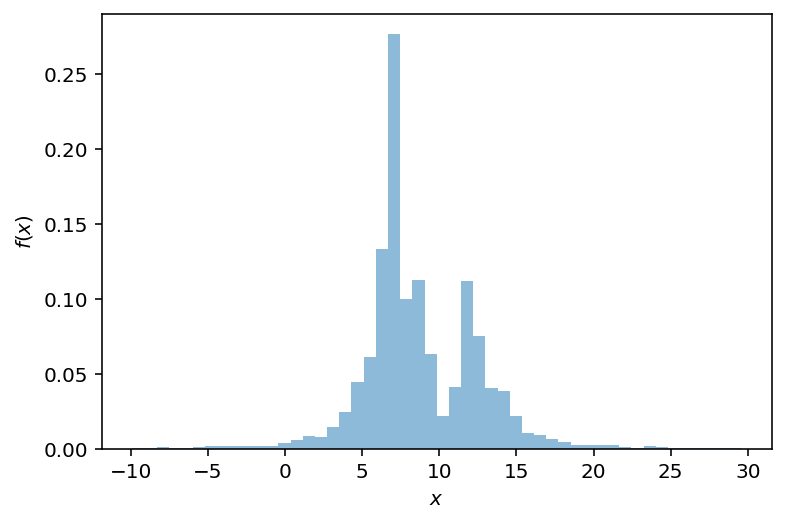

In [3]:
# Execute this cell
# make a histogram to get an idea of what the distribution looks like
plt.hist(data, bins=50, density=True, alpha=0.5);
plt.xlabel('$x$');
plt.ylabel('$f(x)$');

We all know that the **mean** of a sample is 

$$\bar{x} = \frac{1}{N}\sum_{i=1}^N x_i$$ 

This is actually known as the **sample arithmetic mean**, and derives from *Monte Carlo integration* to get the first moment of the distribution, i.e. 

$$\mu = E(x) = \langle x \rangle = \int_{-\infty}^{\infty} x h(x)\,dx \approx \frac{1}{N}\sum_{i=1}^N x_i $$

where $\{x_i\}$ are random samples from the properly normalzied $h(x)$, and $E(\cdot)$ means the **expectation value**. In general we can use random sampling and Monte Carlo integration to deduce integrals over distributions such that 

$$\int_{-\infty}^{\infty} g(x) h(x)\,dx \approx \frac{1}{N}\sum_{i=1}^N g(x_i)$$

In [4]:
# Execute this cell
mean = np.mean(data)
print(mean)

8.707331724932475


While it's most common to compute the mean, it may surprise you to learn that some distributions do not have formally calculable means (integration gives infinity). In these and other cases, the **median** is a more *robust* estimator of the (true) mean location of the distribution.  That's because it is less affected by **outliers**.

To understand the previous statement, think about multiplying all numbers above the 50th percentile (i.e. the median) by 100, or even just replacing them with larger numbers. The mean would be strongly affected by these corrupted points, but **cumulative statistics based on the ordering of samples would remain unaffected by the outlier corruption**.

In [5]:
# Execute this cell.  Think about and discuss what it is doing.
median = np.median(data)

mask = data > 15
data2 = data.copy()
data2[mask] = 100

newmedian = np.median(data2)
newmean = np.mean(data2)

print(median, newmedian)
print(mean, newmean)

7.665858989040229 7.665858989040229
8.707331724932475 12.230618259322716


<font color='red'>Repeat the above masking investigation, but this time multiply all samples above $15$ by a factor of 10. Do you get a similar effect?</font>

In [6]:
mask= data > 15
data3= data.copy()
data3[mask] = data3[mask]*10

newermedian= np.median(data3)
newermean= np.mean(data3)

print(median,newermedian)
print(mean, newermean)

# So clearly I am seeing a lot of contamination from the multiplication by 10, rendering the mean pretty 
# non-representative of this sample

7.665858989040229 7.665858989040229
8.707331724932475 15.637361318438858


Other descriptive statistics are related to higher order moments of the distribution. Beyond the "average" *location* value, we'd like to know something about **deviations** from the average (which is related to the *shape* of the distribution).  The simplest thing to compute is $$d_i = x_i - \mu.$$  However, the average deviation is zero by definition of the mean.  The next simplest thing to do is to compute the **mean absolute deviation (MAD)**:

$$\frac{1}{N}\sum|x_i-\mu|,$$

but the absolute values can hide the true scatter of the distribution [in some cases (see footnote)](http://www.mathsisfun.com/data/standard-deviation.html).  So the next simplest thing to do is to square the differences $$\sigma^2 = \frac{1}{N}\sum(x_i-\mu)^2,$$ which we call the **variance**.

The *variance* $V$ is just expectation value of $(x-\mu)^2$ (and related to the 2nd moment)

$$\sigma^2 = V = E((x-\mu)^2)\int_{-\infty}^{\infty}  (x-\mu)^2 h(x) dx,$$

where $\sigma$ is the **standard deviation**. Again, the integral gets replaced by a sum for discrete distributions. While most familiar for Gaussian distributions, you can compute the variance even if your distribution is not Gaussian.  

In [7]:
# Execute this cell
var = np.var(data)
std = np.std(data)
print(var, std)

14.109284000694963 3.75623268724063


There is also the **Median Absolute Deviation (also MAD)** given by

$${\rm median} (|x_i-{\rm median}(\{x_i\})|)$$

where $\sigma = 1.4826\,{\rm MAD}$ for a Gaussian distribution (but note that we aren't using a Gaussian distribution above).

In [8]:
# Execute this cell
from astropy.stats import median_absolute_deviation
MAD = median_absolute_deviation(data)
print(MAD,MAD*1.4826)

1.5483598496840316 2.295598313141545


**$P\%$ quantiles (or the $p^\mathrm{th}$ percentile, $q_p$)** are computed as
$$\frac{p}{100} = H(q_p) = \int_{-\infty}^{q_p}h(x) dx$$

The full integral from $-\infty$ to $\infty$ is 1 (100%).  So, here you are looking for the value of x that accounts for $p$ percent of the distribution.

For example, the 25th, 50th, and 75th percentiles:

In [9]:
# Execute this cell
q25, q50, q75 = np.percentile(data, [25, 50, 75])
print(q25, q50, q75)

6.674244809830177 7.665858989040229 11.617202241238619


The **interquartile range** is the difference between the 25th and 75th percentiles, $q_{75} - q_{25}$.

Just as with the median, the interquartile range is a more *robust* estimator of the scale of a distribution than the standard deviation.  So, one can create a standard-deviation-esque measurement (at least for a Gaussian) from the interquartile range as

$$\sigma_G = 0.7413\times(q_{75} - q_{25})$$  

The normalization makes it *unbiased* for a perfect Gaussian (more on that later).

In [10]:
# Execute this cell. Think about and discuss the results.
from astroML import stats as astroMLstats

# original data
print(astroMLstats.sigmaG(data), np.std(data))

# corrupted by outliers
print(astroMLstats.sigmaG(data2), np.std(data2))

3.664219826892454 3.75623268724063
3.664219826892454 18.853355225627336


In [11]:
# Execute this cell. Cumulative statistics take longer to compute, but are more robust.
%timeit np.mean(data), np.std(data)
%timeit np.median(data), astroMLstats.sigmaG(data)

73.7 µs ± 7.63 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
461 µs ± 81.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<font color='red'>Make a plot of a histogram of the original data array, and add vertical lines at the 25th, 50th, and 75th percentiles.</font>

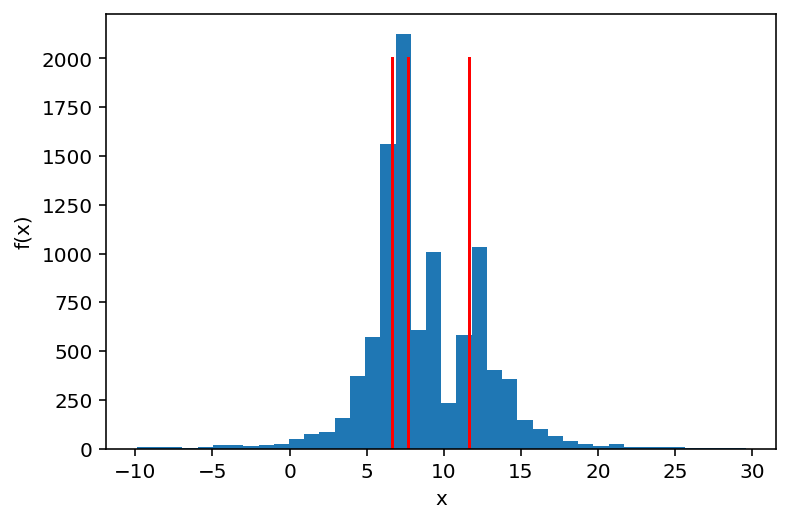

In [12]:
plt.hist(data, bins=40)
plt.plot(np.ones(40)*q25,np.linspace(0,2000,40),'-r')
plt.plot(np.ones(40)*q50,np.linspace(0,2000,40),'-r')
plt.plot(np.ones(40)*q75,np.linspace(0,2000,40),'-r')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

The **mode** is the most probable value, determined from the peak of the distribution, which is the value where the derivative is 0 (i.e. the turning point):

$$ \left(\frac{dh(x)}{dx}\right)_{x_m} = 0$$

Another way to estimate the mode (at least for a Gaussian distribution) is

$$x_m = 3q_{50} - 2\mu$$

In [13]:
# Execute this cell
mode = 3*q50 - 2*mean
print(mode, mean, median)

# Note: don't rely on scipy.stats.mode()
# It gives the most common value of an array, 
# but we have a random sample of unique draws

5.5829135172557365 8.707331724932475 7.665858989040229


Other useful ***shape*** measures include the "higher order" moments (the **skewness** and **kurtosis**):

$$\mathbf{Skewness}\quad\quad \Sigma = \int_{-\infty}^{\infty}  \left(\frac{x-\mu}{\sigma}\right)^3 h(x) dx,$$
 
$$\mathbf{Kurtosis}\quad\quad K = \int_{-\infty}^{\infty}  \left(\frac{x-\mu}{\sigma}\right)^4 h(x) dx  - 3.$$

The skewness measures the distribution's *asymmetry*. Distribution's with long tails to larger $x$ values have positive $\Sigma$. 

The kurtosis measures how peaked or flat-topped a distribution is, with strongly peaked ones being positive and flat-topped ones being negative. $K$ is calibrated to a Gaussian distribution (hence the subtraction of $3$).

![https://www.astroml.org/_images/fig_kurtosis_skew_1.png](https://www.astroml.org/_images/fig_kurtosis_skew_1.png)

In [14]:
# Execute this cell
skew = scipy.stats.skew(data)
kurt = scipy.stats.kurtosis(data)
print(skew, kurt)

0.37223965431728584 2.8833035420731363


In [15]:
# Excute this cell
# Summary descriptive statistics for our distribution
print("Location: ", mean, median, mode)
print("Scale: ", var, std, astroMLstats.sigmaG(data))
print("Shape: ", skew, kurt)
print("Some percentiles: ", q25, q50, q75)

Location:  8.707331724932475 7.665858989040229 5.5829135172557365
Scale:  14.109284000694963 3.75623268724063 3.664219826892454
Shape:  0.37223965431728584 2.8833035420731363
Some percentiles:  6.674244809830177 7.665858989040229 11.617202241238619


## Sample versus Population statistics <a class="anchor" id="two"></a>

Statistics estimated from the *data* are called **sample statistics** as compared to **population statistics** derived from knowing the functional form of the pdf.

Specifically, $\mu$ is the **population mean**, i.e., it is the expecation value of $x$ for $h(x)$.  But we don't *know* $h(x)$.  So the **sample mean**, $\overline{x}$, is an ***estimator*** of $\mu$, defined as

$$\overline{x} \equiv \frac{1}{N}\sum_{i=1}^N x_i,$$

which we determine from the data itself.

Instead of the **population variance** $\sigma^2$, we have the **sample variance**, $s^2$, where

$$s^2 = \frac{1}{N-1}\sum_{i=1}^N(x_i-\overline{x})^2$$

The $N-1$ denominator (instead of $N$) accounts for the fact that we determine $\overline{x}$ from the data itself instead of using a known $\mu$. Ideally one tries to work in a regime where $N$ is large enough that we can be lazy and ignore this. 

So the mean and variance of a distribution are $\mu$ and $\sigma^2$.  The *estimators* of the distribution are $\overline{x}$ (or $\hat{x}$) and $s^2$.

### Uncertainty of sample statistics

We would also like to know the uncertainty of our estimates $\overline{x}$ and $s$.  Note that $s$ is the width estimate of the underlying distribution; it is **NOT** the uncertainty of $\overline{x}$. Rather the uncertainty of $\overline{x}$, $\sigma_{\overline{x}}$ is 

$$ \sigma_{\overline{x}} = \frac{s}{\sqrt{N}},$$

which we call the **standard error of the mean**. The uncertainty of $s$ itself is

$$\sigma_s = \frac{s}{\sqrt{2(N-1)}} = \frac{1}{\sqrt{2}}\sqrt{\frac{N}{N-1}}\sigma_{\overline{x}}.$$

Note that for large $N$, $\sigma_{\overline{x}} \sim \sqrt{2}\sigma_s$ and for small $N$, $\sigma_s$ is not much smaller than $s$.

Another useful uncertainty estimate is for computing quantiles. The **standard error of a quantile** is

$$ \sigma_{q_p} = \frac{1}{h_p}\sqrt{\frac{p(1-p)}{N}}$$

where $p$ is between $0$ and $1$.  

## Univariate distributions <a class="anchor" id="three"></a>

If we are attempting to characterize our data in a way that is **parameterized**, then we need a functional form for a **distribution**.  There are many naturally occurring distributions.  The book goes through quite a few of them.  Here we'll just talk about a few basic ones to get us started.

### Uniform Distribution

The uniform distribution is perhaps more commonly called a "top-hat" or a "box" distribution.  It is specified by a mean, $\mu$, and a width, $W$, where

$$p(x|\mu,W) = \frac{1}{W}$$

over the range $|x-\mu|\le \frac{W}{2}$ and $0$ otherwise.  That says that "given $\mu$ AND $W$, the probability of $x$ is $\frac{1}{W}$" (as long as we are within a certain range).

Since we are used to thinking of a Gaussian as the *only* type of distribution the concept of $\sigma$ (aside from the width) may seem strange.  But $\sigma$ as mathematically defined above applies here and
$$\sigma = \frac{W}{\sqrt{12}}.$$


/Users/keshawnivory/anaconda3/envs/astr8070/lib/python3.8/site-packages/astroML/linear_model/linear_regression_errors.py:8: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


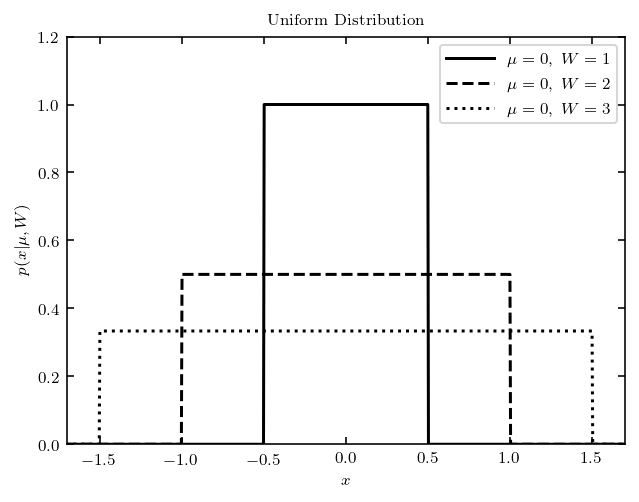

<Figure size 432x288 with 0 Axes>

In [16]:
# Execute this cell (don't worry about warnings)
# Since you're working with a copy of my notebook, you
# may need to change the path below to find the file
%matplotlib inline
%run ../../../lectures/code/fig_uniform_distribution.py

We can implement [uniform](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html#scipy.stats.uniform) in `scipy` as follows.  We'll use the methods listed at the bottom of the link to complete the cell: `dist.rvs(size=N)` which produces `N` random draws from the distribution and `dist.pdf(x)` which returns the value of the pdf at a given $x$. Lots of distributions can be accessed and used in a similar way.  

Create a uniform distribution with parameters `loc=0`,  `scale=2`, and `N=10`.

<font color='red'>Complete and execute the following cell</font>

In [17]:
N = 10 # Complete
distU = scipy.stats.uniform(0,2) # Complete
draws = distU.rvs(size=N) # ten random draws
print(draws)

p = distU.pdf(1) # pdf evaluated at x=1

print(p)

[0.45667133 1.5636436  1.6923709  0.357724   1.56582117 0.82221153
 0.82749487 1.17810633 0.03645514 0.04578631]
0.5


### Gaussian Distribution

As many of you know, the Gaussian distribution pdf is given by

$$p(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)$$

It is also called the **normal distribution** and can be noted by $\mathscr{N}(\mu,\sigma)$.


We love using Gaussians in physics and astronomy because they can approximate many distributions and are also super easy to work with. **The convolution of two Gaussians results in a Gaussian.**  So $\mathscr{N}(\mu_1,\sigma_1)$ convolved with $\mathscr{N}(\mu_2,\sigma_2)$ is $\mathscr{N}(\mu_1+\mu_2,\sqrt{\sigma_1^2+\sigma_2^2})$.

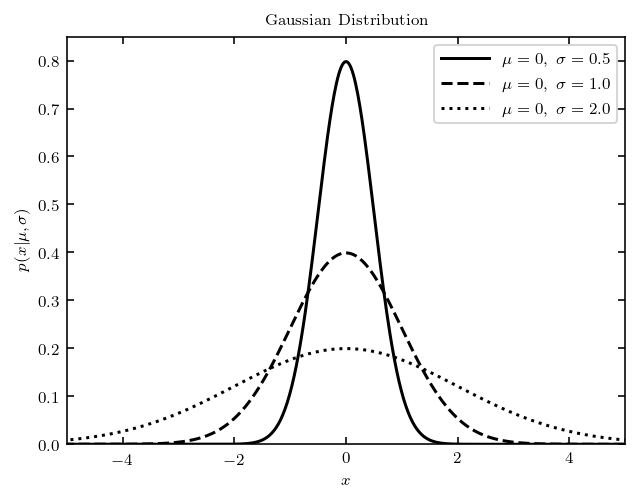

<Figure size 432x288 with 0 Axes>

In [18]:
# Execute this cell
%run ../../../lectures/code/fig_gaussian_distribution.py

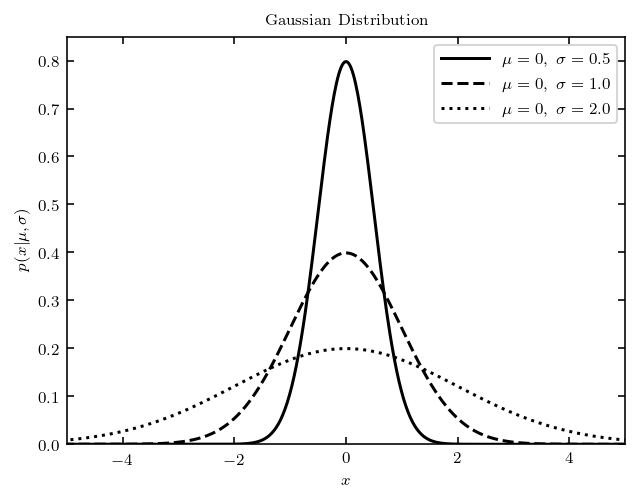

In [19]:
# %load ../../../lectures/code/fig_gaussian_distribution.py
"""
Example of a Gaussian distribution
----------------------------------
Figure 3.8.

This shows an example of a gaussian distribution with various parameters.
We'll generate the distribution using::

    dist = scipy.stats.norm(...)

Where ... should be filled in with the desired distribution parameters
Once we have defined the distribution parameters in this way, these
distribution objects have many useful methods; for example:

* ``dist.pmf(x)`` computes the Probability Mass Function at values ``x``
  in the case of discrete distributions

* ``dist.pdf(x)`` computes the Probability Density Function at values ``x``
  in the case of continuous distributions

* ``dist.rvs(N)`` computes ``N`` random variables distributed according
  to the given distribution

Many further options exist; refer to the documentation of ``scipy.stats``
for more details.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Define the distributions to be plotted
sigma_values = [0.5, 1.0, 2.0]
linestyles = ['-', '--', ':']
mu = 0
x = np.linspace(-10, 10, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(5, 3.75))

for sigma, ls in zip(sigma_values, linestyles):
    # create a gaussian / normal distribution
    dist = norm(mu, sigma)

    plt.plot(x, dist.pdf(x), ls=ls, c='black',
             label=r'$\mu=%i,\ \sigma=%.1f$' % (mu, sigma))

plt.xlim(-5, 5)
plt.ylim(0, 0.85)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\sigma)$')
plt.title('Gaussian Distribution')

plt.legend()
plt.show()


Create a [normal distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html?highlight=stats%20norm#scipy.stats.norm) with `loc=100` and `scale=15`. Produce 10 random draws and determine the probability at `x=145`.

<font color='red'>Complete and execute the following cell</font>

In [20]:
distG = scipy.stats.norm(100,15) # Normal distribution with mean = 100, stdev = 15
draws = distG.rvs(size=N) # 10 random draws
p = distG.pdf(145) # pdf evaluated at x=0 #assuming this should say x=145 to match the question above

print(draws)
print(p)

[ 86.60078655  68.11332847  81.81997296 114.28003379 122.43254064
 106.0394786  108.54159407 100.53031134 103.79300603 137.85838178]
0.0002954565607958672


Make a plot of this Gaussian distribution. Plot the pdf from 0 to 200 with a 1000 gridpoints.  

<font color='red'>Complete and execute the following cell</font>

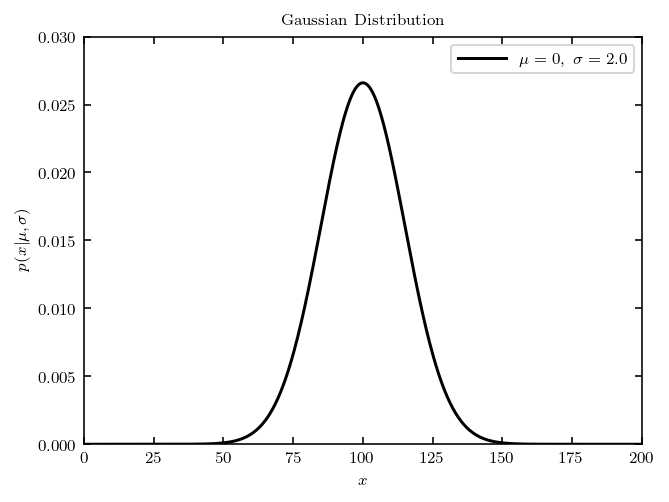

In [21]:
## Let's play with Gaussians! Or Normal distributions, N(mu,sigma)

xgrid = np.linspace(0,200,1000) # generate distribution for a uniform grid of x values
gaussPDF = distG.pdf(xgrid)  # this is a function of xgrid

# actual plotting
fig, ax = plt.subplots(figsize=(5, 3.75))

# Python3 f strings are awesome!
plt.plot(xgrid, gaussPDF, ls='-', c='black', 
         label=f'$\mu={mu},\ \sigma={sigma}$')
plt.xlim(0, 200)
plt.ylim(0, 0.03)
plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\sigma)$')
plt.title('Gaussian Distribution')
plt.legend()

The cumulative distribution function, cdf is the integral of pdf from $x'=-\infty$ to $x'=x$:

$$\mathrm{cdf}(x|\mu,\sigma) = \int_{-\infty}^{x'} p(x'|\mu,\sigma) dx',$$

where $\mathrm{cdf}(\infty) = 1$. 

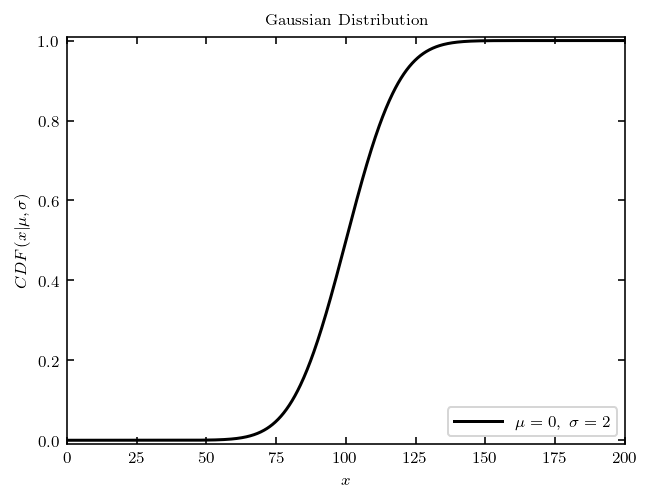

In [22]:
# The same as above but now with the cdf method
gaussCDF = distG.cdf(xgrid)
fig, ax = plt.subplots(figsize=(5, 3.75))
plt.plot(xgrid, gaussCDF, ls='-', c='black', 
         label=r'$\mu=%i,\ \sigma=%i$' % (mu, sigma))
plt.xlim(0, 200)
plt.ylim(-0.01, 1.01)
plt.xlabel('$x$')
plt.ylabel(r'$CDF(x|\mu,\sigma)$')
plt.title('Gaussian Distribution')
plt.legend(loc=4)

#### Gaussian confidence levels

The probability of a measurement drawn from a Gaussian distribution that is between $\mu-a$ and $\mu+b$ is

$$\int_{\mu-a}^{\mu+b} p(x|\mu,\sigma) dx.$$

- For $a=b=1\sigma$, we get the familar result of 68.3%.  
- For $a=b=2\sigma$ it is 95.4%.  
- For $a=b=3\sigma$ it is $99.7\%$. 

So we refer to the range $\mu \pm 1\sigma$, $\mu \pm 2\sigma$, and $\mu \pm 3\sigma$ as the 68%, 95%, and $99.7%$ **confidence limits**, respectively. Note that if your distribution is not Gaussian, then these confidence intervals will be different!

***We often still refer to uncertainty regions of distributions as $1\sigma$ or $2\sigma$ regions, which for non-Gaussian distributions usually means (for $1\sigma$) the region enclosing the $16\%$ and $84\%$ quantiles.***

What is the probability enclosed between $-2\sigma$ and $+4\sigma$? (*Verify first that you get the correct answer for the bullet points above!*)

<font color='red'>Complete and execute the following cell</font>

In [23]:
N=10000
mu=0
sigma=1
distN = scipy.stats.norm(mu, sigma) # Complete
xgrid = np.linspace(-2,4,N) # Complete
dx = (xgrid.max()-xgrid.min())/N
prob = distN.pdf(xgrid)*dx

print(prob.sum())

0.977136709173485


We could do this in various ways. The way you just tried was the most obvious-- brute-force numerical integration with the trapezoidal method. 

But the clever way is to use the cdf, by computing the cdf of the upper integration bound and subtracting the cdf of the lower integration bound.

<font color='red'>Complete and execute the following cell</font>

In [24]:
upper = distN.cdf(4)
lower = distN.cdf(-2)
p = upper-lower
print(p)

0.9772181968099877


### Log Normal

Note that if $x$ is Gaussian distributed with $\mathscr{N}(\mu,\sigma)$, then $y=\exp(x)$ will have a **log-normal** distribution, where the mean of y is $\exp(\mu + \sigma^2/2)$, the median is $\exp(\mu)$, and the mode is $\exp(\mu-\sigma^2)$.  Try it.

In [25]:
# Execute this cell
x = scipy.stats.norm(0,1) # mean = 0, stdev = 1
y = np.exp(x.rvs(100))

print(y.mean())
print(x)

dir(x)

1.6350266393886386


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'a',
 'args',
 'b',
 'cdf',
 'dist',
 'entropy',
 'expect',
 'interval',
 'isf',
 'kwds',
 'logcdf',
 'logpdf',
 'logpmf',
 'logsf',
 'mean',
 'median',
 'moment',
 'pdf',
 'pmf',
 'ppf',
 'random_state',
 'rvs',
 'sf',
 'stats',
 'std',
 'support',
 'var']

The catch here is that stats.norm(0,1) returns an *object* and not something that we can just do math on in the expected manner.  What *can* you do with it?  Try ```dir(x)``` to get a list of all the methods and properties.

In [32]:
# Execute this cell
distLN = scipy.stats.norm(0,1) # mean = 0, stdev = 1
x = distLN.rvs(10000)
y = np.exp(x)

print(np.exp(0 + 0.5*1), y.mean())

1.6487212707001282 1.6566990152376875


<font color='red'>Repeat the above calculations to verify the equations for the mode and median.</font>

In [33]:
print(np.exp(0),np.median(y))
print(np.exp(-1), scipy.stats.mode(y))

1.0 0.9805567708592775
0.36787944117144233 ModeResult(mode=array([0.03257387]), count=array([1]))


SRT: scipy.stats.mode is unreliable, because it looks for the most common value in an array. But we have lots of continuously sampled different numbers. The better way is to find the max location of the histogram.

### $\chi^2$ Distribution

We'll run into the $\chi^2$ distribution when we talk about Maximum Likelihood in the next chapter.

If we have a Gaussian distribution with values ${x_i}$ and we scale and normalize them according to
$$z_i = \frac{x_i-\mu}{\sigma},$$
then the sum of squares, $Q$ 
$$Q = \sum_{i=1}^N z_i^2,$$
will follow the $\chi^2$ distribution.  The *number of degrees of freedom*, $k$ is given by the number of data points, $N$ (minus any constraints).  The pdf of $Q$ given $k$ defines $\chi^2$ and is given by
$$p(Q|k)\equiv \chi^2(Q|k) = \frac{1}{2^{k/2}\Gamma(k/2)}Q^{k/2-1}\exp(-Q/2),$$
where $Q>0$ and the $\Gamma$ function would just be the usual factorial function if we were dealing with integers, but here we have half integers.

This is ugly, but it is really just a formula like anything else.  Note that the shape of the distribution *only* depends on the sample size $N=k$ and not on $\mu$ or $\sigma$.  

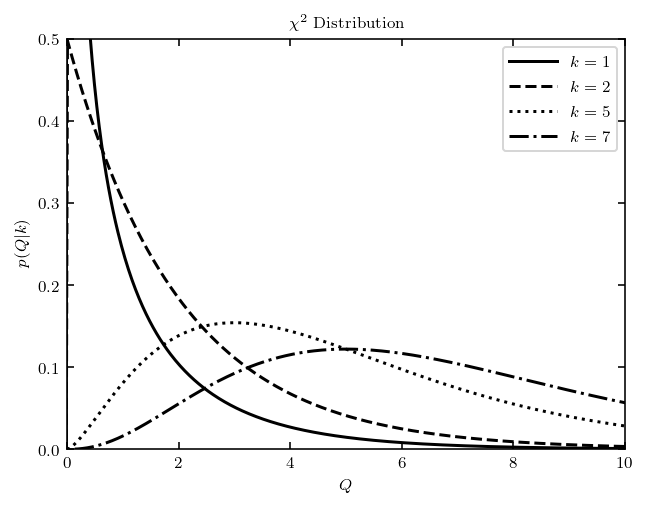

<Figure size 432x288 with 0 Axes>

In [28]:
# Execute this cell
%run ../../../lectures/code/fig_chi2_distribution.py

### Chi-squared per degree of freedom

In practice we frequently divide $\chi^2$ by the number of degrees of freedom, and work with:

$$\chi^2_\mathrm{dof} = \frac{1}{N-1} \sum_{i=1}^N \left(\frac{x_i-\overline{x}}{\sigma}\right)^2$$

which (for large $k$) is distributed as

$$ p(\chi^2_\mathrm{dof}) \sim \mathscr{N}\left(1, \sqrt{\frac{2}{N-1}}\right) $$

(where $k = N-1$, and $N$ is the number of samples). Therefore, we expect $\chi^2_\mathrm{dof}$ to be 1, to within a few $\sqrt{\frac{2}{N-1}}$.

### Poisson distribution

This is a distribution for a discrete variable, telling you the probability of $k$ events occuring within a certain time when the mean is $\mu$. 

An early and famous example of the use of this distribution was to **model the expected number of Prussian cavalrymen that would be kicked to death by their own horse**. Statistics has many applications...

$$ p(k|\mu) = \frac{\mu^k \exp(-\mu)}{k!} $$

where the mean $\mu$ completely characterizes the distribution. The mode is $(\mu-1)$, the standard deviation is $\sqrt{\mu}$, the skewness is $1/\sqrt{\mu}$, and the kurtosis is $1/\mu$.

As $\mu$ increases the Poisson distribution becomes more and more similar to a Gaussian with $\mathcal{N}(\mu,\sqrt{\mu})$. The Poisson distribution is sometimes called the ***law of small numbers*** or ***law of rare events***.

<font color='red'>Complete and execute the following cell for $\mu=3$.</font>

In [38]:
# Practice the Poisson distribution

dist = scipy.stats.poisson(3)

k = dist.rvs(20) # make 20 draws
pmf = dist.pmf(6) # evaluate probability mass function at 6
print(pmf)

0.05040940672246224


### Student's $t$ Distribution

Another distribution that we'll see later is the Student's $t$ Distribution.

If you have a sample of $N$ measurements, $\{x_i\}$, drawn from a Gaussian distribution, $\mathscr{N}(\mu,\sigma)$, and you apply the transform

$$t = \frac{\overline{x}-\mu}{s/\sqrt{N}},$$

then $t$ will be distributed according to Student's $t$ with the following pdf (for $k$ degrees of freedom):

$$p(x|k) = \frac{\Gamma(\frac{k+1}{2})}{\sqrt{\pi k} \Gamma(\frac{k}{2})} \left(1+\frac{x^2}{k}\right)^{-\frac{k+1}{2}}$$

As with a Gaussian, Student's $t$ is bell shaped, but has "heavier" tails.

Note the similarity between $t$ and $z$ for a Gaussian (as defined in the $\chi^2$ section above), which reflects the difference between data-derived estimates of the mean and standard deviation and their true values.

In fact, although often approximated as a Gaussian distribution, the mean of a sample actually follows a Student's $t$ distribution. This matters when sample sizes are small, but mostly irrelevant for "Big Data" examples.

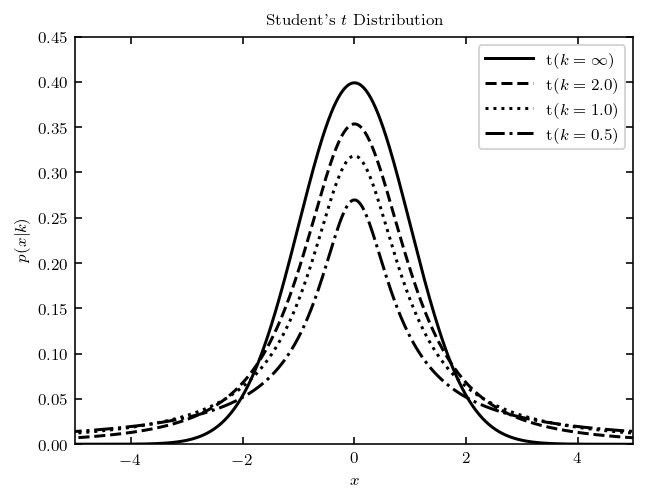

<Figure size 432x288 with 0 Axes>

In [39]:
# Execute this cell
%run ../../../lectures/code/fig_student_t_distribution.py

### What's the point of all these distributions?

* There are many other distributions that we haven't covered here (see the textbook).
* The point is that we are going to make some measurement. 
* To understand the significance of our measurement, we want to know how likely it is that we would get that measurement in our experiment by random chance. 
* To determine that we need to know the shape of the distribution. Let's say that we find that $x=6$. If our data is $\chi^2$ distributed with 2 degrees of freedom, then we would integrate the $k=2$ curve above from 6 to $\infty$ to determine how likely it is that we would have gotten 6 or larger by chance.  If our distribution was instead $t$ distributed, we would get a *very* different answer.  

Note that it is important that you decide *ahead of time* what the metric will be for deciding whether this result is significant or not.  More on this later, but see [this article](http://fivethirtyeight.com/features/science-isnt-broken/).

**FUN FACT:** "Student" was the pen name of W. S. Gosset, who worked for the Guinness brewery in Dublin, Ireland. He was interested in the statistical analysis of small samples, e.g., the chemical properties of barley when the sample size might be as small as $3$.

![https://thatsmaths.files.wordpress.com/2014/04/gosset-plaque.jpg](https://thatsmaths.files.wordpress.com/2014/04/gosset-plaque.jpg)